In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

#Preprocessing
from category_encoders import TargetEncoder, CountEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Model Selection
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split

#Metrics
from sklearn.metrics import mean_squared_error

# Models
from sklearn.linear_model import Lasso, Ridge, ElasticNetCV, ElasticNet
from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC, LinearSVC

#RegressionModels
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb

#Pipeline
from sklearn.pipeline import Pipeline

#other
import os
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install lightgbm

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.4 MB/s eta 0:00:00


## Load Data

In [ ]:
data = pd.read_csv("./training.csv")
#data.replace("Unknown", np.NaN, inplace=True)
#data.replace("Undefined", np.NaN, inplace=True)


print("Main Dataframe Size:",data.shape)
print("\nMain Dataframe:")
data.info()

Main Dataframe Size: (29692, 31)

Main Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29692 entries, 0 to 29691
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    29692 non-null  int64  
 1   surface_x                     29692 non-null  float64
 2   surface_y                     29692 non-null  float64
 3   bh_x                          27605 non-null  float64
 4   bh_y                          27605 non-null  float64
 5   standardized_operator_name    29692 non-null  int64  
 6   gross_perforated_length       22135 non-null  float64
 7   number_of_stages              2752 non-null   float64
 8   total_proppant                19080 non-null  float64
 9   total_fluid                   19076 non-null  float64
 10  true_vertical_depth           28197 non-null  float64
 11  ffs_frac_type                 14585 non-null  object 
 12  proppant_i

In [ ]:
scoring = pd.read_csv("./scoring.csv")
#data.replace("Unknown", np.NaN, inplace=True)
#data.replace("Undefined", np.NaN, inplace=True)


print("Main Dataframe Size:",scoring.shape)
print("\nMain Dataframe:")
scoring.info()

Main Dataframe Size: (400, 30)

Main Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    400 non-null    int64  
 1   surface_x                     400 non-null    float64
 2   surface_y                     400 non-null    float64
 3   bh_x                          400 non-null    float64
 4   bh_y                          400 non-null    float64
 5   standardized_operator_name    400 non-null    int64  
 6   gross_perforated_length       400 non-null    float64
 7   number_of_stages              400 non-null    float64
 8   total_proppant                400 non-null    float64
 9   total_fluid                   400 non-null    float64
 10  true_vertical_depth           400 non-null    float64
 11  ffs_frac_type                 400 non-null    object 
 12  proppant_intensi

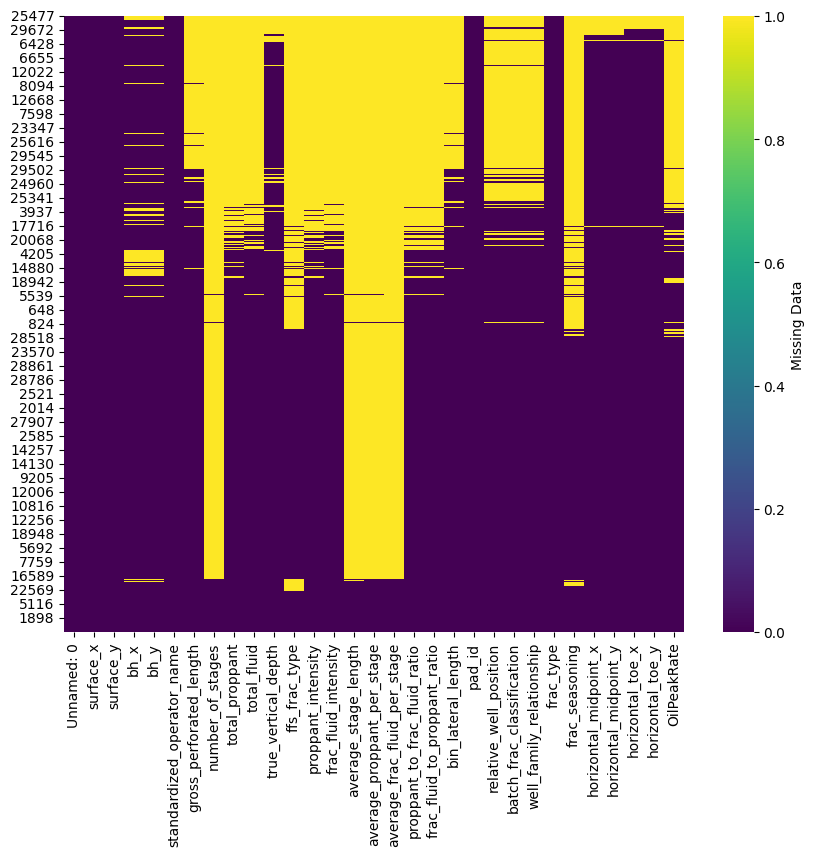

In [ ]:
missing_values_sum = data.isna().sum(axis=1)

# Sort the dataframe based on the sum of missing values
sorted_df = data.iloc[missing_values_sum.sort_values(ascending=False).index]

# Plot the sorted heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sorted_df.isna(), cmap='viridis', cbar_kws={'label': 'Missing Data'})
plt.show()

In [ ]:
data_x = data.dropna(subset=['OilPeakRate'])

missing_dict = {}

for i in data.columns:
    missing_dict[i] = [100*(data[i].isna().sum())/len(data), 100*(data_x[i].isna().sum())/len(data_x)]

midding_df = pd.DataFrame(missing_dict).transpose()
midding_df.columns = ["% Missing", "% Missing w/ dropped OilPeakRate"]
midding_df

,% Missing,% Missing w/ dropped OilPeakRate
Unnamed: 0,0.000000,0.000000
surface_x,0.000000,0.000000
surface_y,0.000000,0.000000
bh_x,7.028829,7.375945
bh_y,7.028829,7.375945
standardized_operator_name,0.000000,0.000000
gross_perforated_length,25.451300,0.818398
number_of_stages,90.731510,86.309955
total_proppant,35.740267,7.220553
total_fluid,35.753738,7.458821


# Data Wrangling
1. Drop outliers
2. drop unnecessary features


In [ ]:
#Drop outlier (infinity)
data = data[data["frac_fluid_to_proppant_ratio"] != np.inf]
data = data[data["total_proppant"] != 0]

In [ ]:
#Drop Unnecessary Features
features_to_drop = ['standardized_operator_name', 'number_of_stages', 'average_stage_length', 'average_proppant_per_stage', 'average_frac_fluid_per_stage', 'pad_id', 'frac_type' ]
data.drop(columns = features_to_drop, inplace = True)



In [ ]:
features_to_drop = ['standardized_operator_name', 'number_of_stages', 'average_stage_length', 'average_proppant_per_stage', 'average_frac_fluid_per_stage', 'pad_id', 'frac_type' ]
scoring.drop(columns = features_to_drop, inplace = True)

In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 29689 entries, 0 to 29691
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    29689 non-null  int64  
 1   surface_x                     29689 non-null  float64
 2   surface_y                     29689 non-null  float64
 3   bh_x                          27604 non-null  float64
 4   bh_y                          27604 non-null  float64
 5   gross_perforated_length       22132 non-null  float64
 6   total_proppant                19077 non-null  float64
 7   total_fluid                   19073 non-null  float64
 8   true_vertical_depth           28194 non-null  float64
 9   ffs_frac_type                 14584 non-null  object 
 10  proppant_intensity            18970 non-null  float64
 11  frac_fluid_intensity          18945 non-null  float64
 12  proppant_to_frac_fluid_ratio  18655 non-null  float64
 13  f

In [ ]:
#data_notna = data[data['OilPeakRate'].notna()]

# Feature Engineering (Pre Train-Val-Test Split)

In [ ]:
#distances
data['dist_surf_bh'] = np.sqrt((data['surface_x'] - data['bh_x'])**2 + (data['surface_y'] - data['bh_y'])**2)

data['dist_surf_hm'] = np.sqrt((data['surface_x'] - data['horizontal_midpoint_x'])**2 + (data['surface_y'] - data['horizontal_midpoint_y'])**2)

data['dist_surf_ht'] = np.sqrt((data['surface_x'] - data['horizontal_toe_x'])**2 + (data['surface_y'] - data['horizontal_toe_x'])**2)



In [ ]:
#log features
log_features = ['total_proppant',  'proppant_intensity',
                'proppant_to_frac_fluid_ratio','frac_fluid_to_proppant_ratio']


for feature in log_features:
  feature_name = f'log_{feature}'
  moo = np.log(data[feature])
  data[feature_name] = moo


In [ ]:
#categorical features
cat_missing_impute_feature = ['ffs_frac_type','batch_frac_classification']
for feature in cat_missing_impute_feature:
  data[feature] = data[feature].fillna("Missing")

In [ ]:

# generate projection group
data["projection_group"] = (
    data["relative_well_position"].astype(str)
    + "_to_"
    + data["well_family_relationship"].astype(str)
)


In [ ]:

#drop old columns
features_to_drop = log_features + ['horizontal_midpoint_x','horizontal_midpoint_y','horizontal_toe_x', 'horizontal_toe_y', 'bh_x', 'bh_y' ]
data.drop(columns = features_to_drop, inplace = True)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29689 entries, 0 to 29691
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        29689 non-null  int64  
 1   surface_x                         29689 non-null  float64
 2   surface_y                         29689 non-null  float64
 3   gross_perforated_length           22132 non-null  float64
 4   total_fluid                       19073 non-null  float64
 5   true_vertical_depth               28194 non-null  float64
 6   ffs_frac_type                     29689 non-null  object 
 7   frac_fluid_intensity              18945 non-null  float64
 8   bin_lateral_length                22132 non-null  float64
 9   relative_well_position            20465 non-null  object 
 10  batch_frac_classification         29689 non-null  object 
 11  well_family_relationship          20465 non-null  object 
 12  frac

In [ ]:
data.columns

Index(['Unnamed: 0', 'surface_x', 'surface_y', 'gross_perforated_length',
       'total_fluid', 'true_vertical_depth', 'ffs_frac_type',
       'frac_fluid_intensity', 'bin_lateral_length', 'relative_well_position',
       'batch_frac_classification', 'well_family_relationship',
       'frac_seasoning', 'OilPeakRate', 'dist_surf_bh', 'dist_surf_hm',
       'dist_surf_ht', 'log_total_proppant', 'log_proppant_intensity',
       'log_proppant_to_frac_fluid_ratio', 'log_frac_fluid_to_proppant_ratio',
       'projection_group'],
      dtype='object')

In [ ]:
numerical_features = ['surface_x', 'surface_y', 'gross_perforated_length',
        'bin_lateral_length',
       'frac_seasoning', 'dist_surf_bh', 'dist_surf_hm',
       'dist_surf_ht', 'log_total_proppant', 'total_fluid',
       'true_vertical_depth', 'log_proppant_intensity',
       'frac_fluid_intensity', 'log_proppant_to_frac_fluid_ratio',
       'log_frac_fluid_to_proppant_ratio']

categorical_features = ['ffs_frac_type', 'relative_well_position',
       'batch_frac_classification', 'well_family_relationship', 'projection_group']

features = numerical_features + categorical_features
target = ['OilPeakRate']



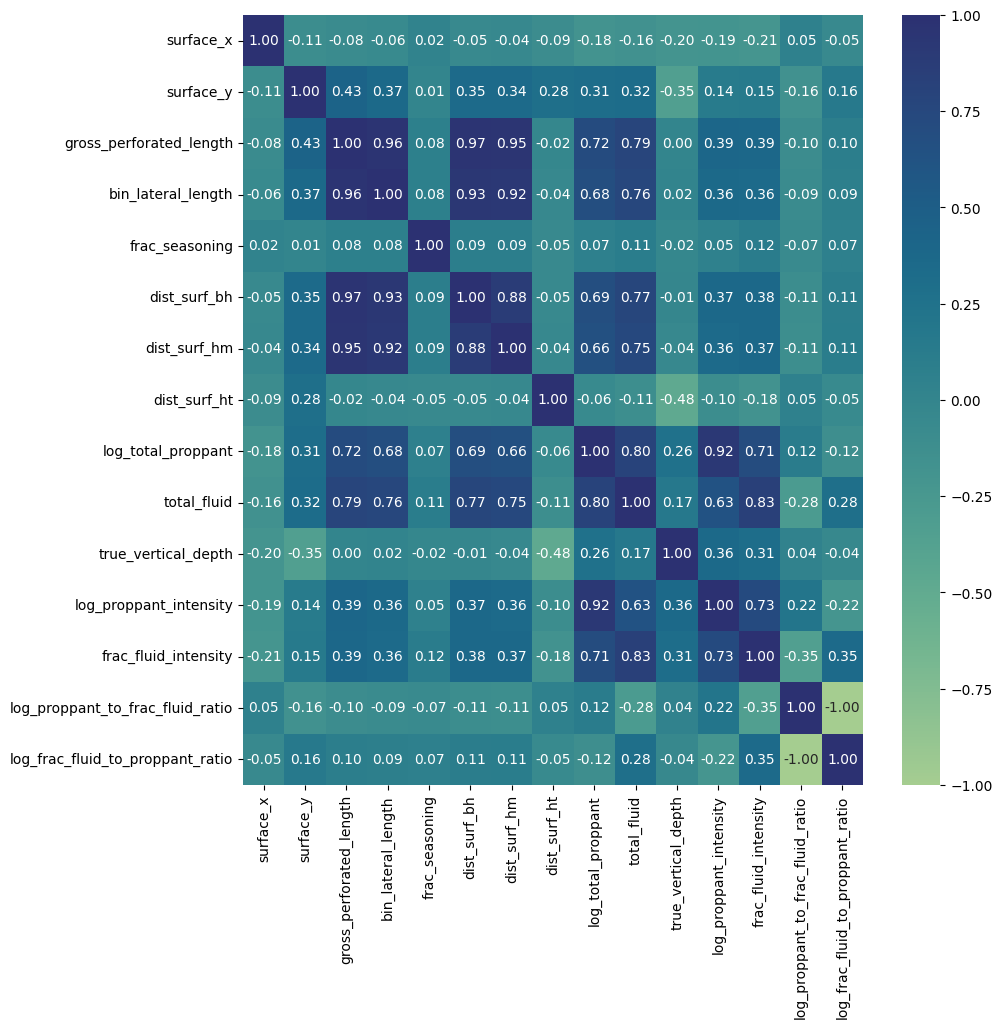

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(data[numerical_features].corr(), annot=True, fmt=".2f",  cmap="crest")
plt.show()

In [ ]:
#scoring

#distances
scoring['dist_surf_bh'] = np.sqrt((scoring['surface_x'] - scoring['bh_x'])**2 + (scoring['surface_y'] - scoring['bh_y'])**2)

scoring['dist_surf_hm'] = np.sqrt((scoring['surface_x'] - scoring['horizontal_midpoint_x'])**2 + (scoring['surface_y'] - scoring['horizontal_midpoint_y'])**2)

scoring['dist_surf_ht'] = np.sqrt((scoring['surface_x'] - scoring['horizontal_toe_x'])**2 + (scoring['surface_y'] - scoring['horizontal_toe_x'])**2)

#log features
log_features = ['total_proppant',  'proppant_intensity',
                'proppant_to_frac_fluid_ratio','frac_fluid_to_proppant_ratio']


for feature in log_features:
  feature_name = f'log_{feature}'
  moo = np.log(scoring[feature])
  scoring[feature_name] = moo

  #categorical features
cat_missing_impute_feature = ['ffs_frac_type','batch_frac_classification']
for feature in cat_missing_impute_feature:
  scoring[feature] = scoring[feature].fillna("Missing")


# generate projection group
scoring["projection_group"] = (
    scoring["relative_well_position"].astype(str)
    + "_to_"
    + scoring["well_family_relationship"].astype(str)
)


#drop old columns
features_to_drop = log_features + ['horizontal_midpoint_x','horizontal_midpoint_y','horizontal_toe_x', 'horizontal_toe_y', 'bh_x', 'bh_y' ]
scoring.drop(columns = features_to_drop, inplace = True)



In [ ]:
scoring[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   surface_x                         400 non-null    float64
 1   surface_y                         400 non-null    float64
 2   gross_perforated_length           400 non-null    float64
 3   bin_lateral_length                400 non-null    float64
 4   frac_seasoning                    400 non-null    float64
 5   dist_surf_bh                      400 non-null    float64
 6   dist_surf_hm                      400 non-null    float64
 7   dist_surf_ht                      400 non-null    float64
 8   log_total_proppant                400 non-null    float64
 9   total_fluid                       400 non-null    float64
 10  true_vertical_depth               400 non-null    float64
 11  log_proppant_intensity            400 non-null    float64
 12  frac_flu

# Train Test Split

In [ ]:
# split data
#Get Training Set
X_train, X_temp, y_train, y_temp = train_test_split(data[features], data[target], test_size=0.3, random_state=20)

# Second, split the temporary set into validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=20)

# Combine training and validation sets for tuned model training
X_train_combined = pd.concat([X_train, X_valid], axis=0)
y_train_combined = pd.concat([y_train, y_valid], axis=0)

In [ ]:
X_train['log_total_proppant'].min()

8.371258666459502

In [ ]:
#Simple mean impute of NaN values in log_features
for group in [X_train, X_valid, X_test, X_train_combined]:
  for feature in log_features:
    imputer = SimpleImputer(strategy="mean")
    group["log_" + feature] = imputer.fit_transform(group["log_" + feature].values.reshape(-1, 1)).flatten()


In [ ]:
#Simple mean impute of NaN values in log_features
for group in [X_train, X_valid, X_test, X_train_combined]:
  for feature in ['true_vertical_depth', 'total_fluid', 'frac_fluid_intensity']:
    imputer = SimpleImputer(strategy="mean")
    group[feature] = imputer.fit_transform(group[feature].values.reshape(-1, 1)).flatten()

In [ ]:
X_train.isna().sum()

surface_x                               0
surface_y                               0
gross_perforated_length              5275
bin_lateral_length                   5275
frac_seasoning                      10411
dist_surf_bh                         1443
dist_surf_hm                          690
dist_surf_ht                          482
log_total_proppant                      0
total_fluid                             0
true_vertical_depth                     0
log_proppant_intensity                  0
frac_fluid_intensity                    0
log_proppant_to_frac_fluid_ratio        0
log_frac_fluid_to_proppant_ratio        0
ffs_frac_type                           0
relative_well_position               6448
batch_frac_classification               0
well_family_relationship             6448
projection_group                        0
dtype: int64

# Drop NaN rows


In [ ]:
#before
for group in [(X_train, y_train), (X_valid, y_valid), (X_test,y_test), (X_train_combined,y_train_combined)]:
  print(group[0].shape , group[1].shape
  )

(20782, 20) (20782, 1)
(4453, 20) (4453, 1)
(4454, 20) (4454, 1)
(25235, 20) (25235, 1)


In [ ]:
X_train.columns

Index(['surface_x', 'surface_y', 'gross_perforated_length',
       'bin_lateral_length', 'frac_seasoning', 'dist_surf_bh', 'dist_surf_hm',
       'dist_surf_ht', 'log_total_proppant', 'total_fluid',
       'true_vertical_depth', 'log_proppant_intensity', 'frac_fluid_intensity',
       'log_proppant_to_frac_fluid_ratio', 'log_frac_fluid_to_proppant_ratio',
       'ffs_frac_type', 'relative_well_position', 'batch_frac_classification',
       'well_family_relationship', 'projection_group'],
      dtype='object')

In [ ]:
columns_to_check_na =['gross_perforated_length',
       'bin_lateral_length',
       'relative_well_position',
       'well_family_relationship',
        'dist_surf_hm',
        'dist_surf_ht']

In [ ]:
nan_indices = X_train[columns_to_check_na].isna().any(axis=1)

# Drop rows with NaN values from X_train
X_train_no_nan = X_train[~nan_indices]

# Drop corresponding rows from y_train
y_train_no_nan = y_train[~nan_indices]


In [ ]:
nan_indices = X_valid[columns_to_check_na].isna().any(axis=1)

# Drop rows with NaN values from X_train
X_valid_no_nan = X_valid[~nan_indices]

# Drop corresponding rows from y_train
y_valid_no_nan = y_valid[~nan_indices]

In [ ]:
nan_indices = X_test[columns_to_check_na].isna().any(axis=1)

# Drop rows with NaN values from X_train
X_test_no_nan = X_test[~nan_indices]

# Drop corresponding rows from y_train
y_test_no_nan = y_test[~nan_indices]

In [ ]:
nan_indices = X_train_combined[columns_to_check_na].isna().any(axis=1)

# Drop rows with NaN values from X_train
X_combined_no_nan = X_train_combined[~nan_indices]

# Drop corresponding rows from y_train
y_combined_no_nan = y_train_combined[~nan_indices]

In [ ]:
for group in [(X_train_no_nan, y_train_no_nan), (X_valid_no_nan, y_valid_no_nan),
              (X_test_no_nan,y_test_no_nan), (X_combined_no_nan,y_combined_no_nan)]:
  print(group[0].shape , group[1].shape
  )

(14016, 20) (14016, 1)
(3015, 20) (3015, 1)
(2978, 20) (2978, 1)
(17031, 20) (17031, 1)


In [ ]:
for group in [(X_train_no_nan, y_train_no_nan), (X_valid_no_nan, y_valid_no_nan),
              (X_test_no_nan,y_test_no_nan), (X_combined_no_nan,y_combined_no_nan)]:
  print(group[0].shape , group[1].shape
  )

(14016, 20) (14016, 1)
(3015, 20) (3015, 1)
(2978, 20) (2978, 1)
(17031, 20) (17031, 1)


In [ ]:
X_train_no_nan.isna().sum()

surface_x                              0
surface_y                              0
gross_perforated_length                0
bin_lateral_length                     0
frac_seasoning                      3683
dist_surf_bh                        1090
dist_surf_hm                           0
dist_surf_ht                           0
log_total_proppant                     0
total_fluid                            0
true_vertical_depth                    0
log_proppant_intensity                 0
frac_fluid_intensity                   0
log_proppant_to_frac_fluid_ratio       0
log_frac_fluid_to_proppant_ratio       0
ffs_frac_type                          0
relative_well_position                 0
batch_frac_classification              0
well_family_relationship               0
projection_group                       0
dtype: int64

# Predictive Imputation

In [ ]:
for group in [X_train_no_nan, X_valid_no_nan, X_test_no_nan, X_combined_no_nan]:

    # Identify the column with missing values
    imputation_target = 'dist_surf_bh'

    # Identify features for imputation
    features_for_imputation = ['surface_x', 'surface_y', 'gross_perforated_length']

    # Create a DataFrame with selected features for imputation
    features = group[features_for_imputation]

    # Separate rows with and without missing values in the target column
    rows_with_missing = group[imputation_target].isna()
    rows_without_missing = ~rows_with_missing

    # Create a linear regression model
    model = LinearRegression()

    # Train the model on non-missing values
    model.fit(features.loc[rows_without_missing], group[imputation_target].dropna())

    # Predict missing values
    predictions = model.predict(features)

    # Replace missing values in the specific column with predictions
    group[imputation_target] = np.where(rows_with_missing, predictions, group[imputation_target])

<ipython-input-42-c994a42f1d22>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group[imputation_target] = np.where(rows_with_missing, predictions, group[imputation_target])
<ipython-input-42-c994a42f1d22>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group[imputation_target] = np.where(rows_with_missing, predictions, group[imputation_target])
<ipython-input-42-c994a42f1d22>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [ ]:
X_train_no_nan.isna().sum()

surface_x                              0
surface_y                              0
gross_perforated_length                0
bin_lateral_length                     0
frac_seasoning                      3683
dist_surf_bh                           0
dist_surf_hm                           0
dist_surf_ht                           0
log_total_proppant                     0
total_fluid                            0
true_vertical_depth                    0
log_proppant_intensity                 0
frac_fluid_intensity                   0
log_proppant_to_frac_fluid_ratio       0
log_frac_fluid_to_proppant_ratio       0
ffs_frac_type                          0
relative_well_position                 0
batch_frac_classification              0
well_family_relationship               0
projection_group                       0
dtype: int64

In [ ]:
for group in [X_train_no_nan, X_valid_no_nan, X_test_no_nan, X_combined_no_nan]:

    imputation_target = 'frac_seasoning'

    # Identify features for imputation
    features_for_imputation = [col for col in group.columns if col != imputation_target]

    # Identify categorical features
    categorical_features = group.select_dtypes(include='object').columns

    # Create a DataFrame with all features except the target for imputation
    features = group[features_for_imputation]

    # Separate rows with and without missing values in the target column
    rows_with_missing = group[imputation_target].isna()
    rows_without_missing = ~rows_with_missing

    # Create a linear regression model
    model = LinearRegression()

    # Create a column transformer for preprocessing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', features.select_dtypes(include='number').columns),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ])

    # Train the model on non-missing values
    model.fit(preprocessor.fit_transform(features.loc[rows_without_missing]), group[imputation_target].dropna())

    # Transform features for prediction
    features_transformed = preprocessor.transform(features)

    # Predict missing values
    predictions = model.predict(features_transformed)

    # Replace missing values in the specific column with predictions
    group[imputation_target] = np.where(rows_with_missing, predictions, group[imputation_target])

<ipython-input-44-465d5df184aa>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group[imputation_target] = np.where(rows_with_missing, predictions, group[imputation_target])
<ipython-input-44-465d5df184aa>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group[imputation_target] = np.where(rows_with_missing, predictions, group[imputation_target])
<ipython-input-44-465d5df184aa>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [ ]:
X_train_no_nan.isna().sum()

surface_x                           0
surface_y                           0
gross_perforated_length             0
bin_lateral_length                  0
frac_seasoning                      0
dist_surf_bh                        0
dist_surf_hm                        0
dist_surf_ht                        0
log_total_proppant                  0
total_fluid                         0
true_vertical_depth                 0
log_proppant_intensity              0
frac_fluid_intensity                0
log_proppant_to_frac_fluid_ratio    0
log_frac_fluid_to_proppant_ratio    0
ffs_frac_type                       0
relative_well_position              0
batch_frac_classification           0
well_family_relationship            0
projection_group                    0
dtype: int64

In [ ]:
for group in [(X_train_no_nan, y_train_no_nan), (X_valid_no_nan, y_valid_no_nan),
              (X_test_no_nan,y_test_no_nan), (X_combined_no_nan,y_combined_no_nan)]:
  print(group[0].shape , group[1].shape)

(14016, 20) (14016, 1)
(3015, 20) (3015, 1)
(2978, 20) (2978, 1)
(17031, 20) (17031, 1)


#OilPeakRate nans

In [ ]:
nan_indices = y_train_no_nan.isna().any(axis=1)

# Drop rows with NaN values from X_train
X_train_no_nan = X_train_no_nan[~nan_indices]

# Drop corresponding rows from y_train
y_train_no_nan = y_train_no_nan[~nan_indices]


In [ ]:
nan_indices = y_valid_no_nan.isna().any(axis=1)

# Drop rows with NaN values from X_train
X_valid_no_nan = X_valid_no_nan[~nan_indices]

# Drop corresponding rows from y_train
y_valid_no_nan = y_valid_no_nan[~nan_indices]

In [ ]:
nan_indices = y_test_no_nan.isna().any(axis=1)

# Drop rows with NaN values from X_train
X_test_no_nan = X_test_no_nan[~nan_indices]

# Drop corresponding rows from y_train
y_test_no_nan = y_test_no_nan[~nan_indices]

In [ ]:
nan_indices = y_combined_no_nan.isna().any(axis=1)

# Drop rows with NaN values from X_train
X_combined_no_nan = X_combined_no_nan[~nan_indices]

# Drop corresponding rows from y_train
y_combined_no_nan = y_combined_no_nan[~nan_indices]

In [ ]:
X_combined_no_nan.isna().sum()

surface_x                           0
surface_y                           0
gross_perforated_length             0
bin_lateral_length                  0
frac_seasoning                      0
dist_surf_bh                        0
dist_surf_hm                        0
dist_surf_ht                        0
log_total_proppant                  0
total_fluid                         0
true_vertical_depth                 0
log_proppant_intensity              0
frac_fluid_intensity                0
log_proppant_to_frac_fluid_ratio    0
log_frac_fluid_to_proppant_ratio    0
ffs_frac_type                       0
relative_well_position              0
batch_frac_classification           0
well_family_relationship            0
projection_group                    0
dtype: int64

In [ ]:
for group in [(X_train_no_nan, y_train_no_nan), (X_valid_no_nan, y_valid_no_nan),
              (X_test_no_nan,y_test_no_nan), (X_combined_no_nan,y_combined_no_nan)]:
  print(group[0].shape , group[1].shape)

(13419, 20) (13419, 1)
(2862, 20) (2862, 1)
(2842, 20) (2842, 1)
(16281, 20) (16281, 1)


#Engineered Features

In [ ]:
y_train_no_nan.columns.to_list()

['OilPeakRate']

In [ ]:
# Convert NumPy arrays to DataFrames
X_train_no_nan_df = pd.DataFrame(X_train_no_nan, columns=X_train_no_nan.columns.to_list())  # Replace column names accordingly
y_train_no_nan_df = pd.DataFrame(y_train_no_nan, columns=y_train_no_nan.columns.to_list())  # Replace with your actual target column name

# Concatenate DataFrames along columns
combined_df = pd.concat([X_train_no_nan_df, y_train_no_nan_df], axis=1)

# Export the combined DataFrame to CSV
combined_df.to_csv('/train_data.csv', index=False)

In [ ]:
# Convert NumPy arrays to DataFrames
X_valid_no_nan_df = pd.DataFrame(X_valid_no_nan, columns=X_valid_no_nan.columns.to_list())  # Replace column names accordingly
y_valid_no_nan_df = pd.DataFrame(y_valid_no_nan, columns=y_valid_no_nan.columns.to_list())  # Replace with your actual target column name

# Concatenate DataFrames along columns
combined_df = pd.concat([X_valid_no_nan_df, y_valid_no_nan_df], axis=1)

# Export the combined DataFrame to CSV
combined_df.to_csv('/valid_data.csv', index=False)

#Models
## Linear Regression Friends


In [ ]:
X_combined_no_nan.columns.to_list()

['surface_x',
 'surface_y',
 'gross_perforated_length',
 'bin_lateral_length',
 'frac_seasoning',
 'dist_surf_bh',
 'dist_surf_hm',
 'dist_surf_ht',
 'log_total_proppant',
 'log_total_fluid',
 'log_true_vertical_depth',
 'log_proppant_intensity',
 'log_frac_fluid_intensity',
 'log_proppant_to_frac_fluid_ratio',
 'log_frac_fluid_to_proppant_ratio',
 'ffs_frac_type',
 'relative_well_position',
 'batch_frac_classification',
 'well_family_relationship',
 'projection_group']

In [ ]:
numerical_features = ['surface_x',
                'surface_y',
                'gross_perforated_length',
                'bin_lateral_length',
                'frac_seasoning',
                'dist_surf_bh',
                'dist_surf_hm',
                'dist_surf_ht',
                'log_total_proppant',
                'log_total_fluid',
                'log_true_vertical_depth',
                'log_proppant_intensity',
                'log_frac_fluid_intensity',
                'log_proppant_to_frac_fluid_ratio',
                'log_frac_fluid_to_proppant_ratio']
categorical_features = ['ffs_frac_type',
                'relative_well_position',
                'batch_frac_classification',
                'well_family_relationship',
                'projection_group']

In [ ]:
# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the pipeline with preprocessing and Lasso regression
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso(random_state=20, alpha=0.1))  # Adjust the alpha parameter as needed
])

# Fit the Lasso pipeline
lasso_pipeline.fit(X_train_no_nan, y_train_no_nan)

# Evaluate the model on the test set
y_pred = lasso_pipeline.predict(X_valid_no_nan)
mse = mean_squared_error(y_valid_no_nan, y_pred, squared = False)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 113.60355565325413


Ridge

In [ ]:
# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the pipeline with preprocessing and Lasso regression
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge(random_state=20, alpha=20))  # Adjust the alpha parameter as needed
])

# Fit the Lasso pipeline
lasso_pipeline.fit(X_train_no_nan, y_train_no_nan)

# Evaluate the model on the test set
y_pred = lasso_pipeline.predict(X_valid_no_nan)
mse = mean_squared_error(y_valid_no_nan, y_pred, squared = False)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 114.02765576777978


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the pipeline with preprocessing and ElasticNetCV
elastic_net_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('elastic_net', ElasticNetCV(alphas=[0.1, 1.0, 10.0], l1_ratio=[0,0.25, 0.5,0.75, 1], cv=5))  # Adjust alphas and l1_ratio as needed
])

# Fit the ElasticNetCV pipeline
elastic_net_pipeline.fit(X_combined_no_nan, y_combined_no_nan)

#
cv_rmse = np.sqrt(-cross_val_score(elastic_net_pipeline, X_train_no_nan, y_train_no_nan, scoring='neg_mean_squared_error', cv=5))
average_cv_rmse = cv_rmse.mean()

# Print the cross-validated root mean squared error
print(f'Cross-validated Root Mean Squared Error: {average_cv_rmse}')

# Print the best hyperparameters found by ElasticNetCV
print(f'Best alpha: {elastic_net_pipeline.named_steps["elastic_net"].alpha_}')
print(f'Best l1_ratio: {elastic_net_pipeline.named_steps["elastic_net"].l1_ratio_}')

Cross-validated Root Mean Squared Error: 122.1589227496066
Best alpha: 0.1
Best l1_ratio: 1.0


In [ ]:
# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the pipeline with preprocessing and Lasso regression
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('elnet', ElasticNet(random_state=10, alpha=0.01, l1_ratio = 0.6))  # Adjust the alpha parameter as needed
])

# Fit the Lasso pipeline
lasso_pipeline.fit(X_combined_no_nan, y_combined_no_nan)

# Evaluate the model on the test set
y_pred = lasso_pipeline.predict(X_test_no_nan)
mse = mean_squared_error(y_test_no_nan, y_pred, squared = False)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 125.73746268445285


#KNN


In [ ]:
# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the pipeline with preprocessing and Lasso regression
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('KNN', KNeighborsRegressor(n_neighbors= 7))])

# Fit the Lasso pipeline
lasso_pipeline.fit(X_combined_no_nan, y_combined_no_nan)

# Evaluate the model on the test set
y_pred = lasso_pipeline.predict(X_test_no_nan)
mse = mean_squared_error(y_test_no_nan, y_pred, squared = False)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 118.29644930838053


#Emsemble Methods

#RandomForest

In [ ]:

# Get the feature names after one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the pipeline with preprocessing and XGBoost Regressor
xgboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgboost', XGBRegressor(random_state=20, objective='reg:squarederror'))  # Adjust parameters as needed
])

# Fit the XGBoost pipeline on the training data
xgboost_pipeline.fit(X_train_no_nan, y_train_no_nan)

# Predict on the validation set
y_pred = xgboost_pipeline.predict(X_valid_no_nan)

# Calculate the root mean squared error on the validation set
rmse = np.sqrt(mean_squared_error(y_valid_no_nan, y_pred))
print(f'Root Mean Squared Error on Validation Set: {rmse}')


Root Mean Squared Error on Validation Set: 100.5923719241239


In [ ]:
param_grid = {
    'xgboost__learning_rate': [0.01, 0.1, 0.2],
    'xgboost__max_depth': [5, 8, 12],
    'xgboost__subsample': [0.8, 1.0],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(xgboost_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_combined_no_nan, y_combined_no_nan)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model from the grid search
best_xgboost_model = grid_search.best_estimator_

# Predict on the validation set using the best model
y_pred_best = best_xgboost_model.predict(X_test_no_nan)

# Calculate the root mean squared error on the validation set
rmse_best = np.sqrt(mean_squared_error(y_test_no_nan, y_pred_best))
print(f'Root Mean Squared Error with Best Model: {rmse_best}')

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Hyperparameters: {'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 8, 'xgboost__subsample': 0.8}
Root Mean Squared Error with Best Model: 100.87006788555902


#CatBoost


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
    ])

# Define the pipeline with preprocessing and CatBoost Regressor
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('catboost', CatBoostRegressor(random_state=20, objective='RMSE'))  # Adjust parameters as needed
])

# Fit the CatBoost pipeline on the training data
catboost_pipeline.fit(X_train_no_nan, y_train_no_nan)

# Predict on the validation set
y_pred = catboost_pipeline.predict(X_valid_no_nan)

# Calculate the root mean squared error on the validation set
rmse = np.sqrt(mean_squared_error(y_valid_no_nan, y_pred))
print(f'Root Mean Squared Error on Validation Set: {rmse}')

Learning rate set to 0.061711
0:	learn: 152.4466187	total: 9.2ms	remaining: 9.19s
1:	learn: 149.3930620	total: 15.5ms	remaining: 7.75s
2:	learn: 146.5282499	total: 21.9ms	remaining: 7.28s
3:	learn: 143.8437843	total: 29.1ms	remaining: 7.25s
4:	learn: 141.4781267	total: 35.6ms	remaining: 7.09s
5:	learn: 139.1881866	total: 44.3ms	remaining: 7.34s
6:	learn: 137.1463576	total: 50.7ms	remaining: 7.19s
7:	learn: 135.2072130	total: 56.7ms	remaining: 7.03s
8:	learn: 133.5121864	total: 62.8ms	remaining: 6.91s
9:	learn: 131.9430375	total: 70.4ms	remaining: 6.97s
10:	learn: 130.6073833	total: 79.4ms	remaining: 7.13s
11:	learn: 129.3323079	total: 86.4ms	remaining: 7.12s
12:	learn: 128.1207548	total: 95.8ms	remaining: 7.27s
13:	learn: 127.0286736	total: 103ms	remaining: 7.27s
14:	learn: 125.9340297	total: 110ms	remaining: 7.23s
15:	learn: 124.9434011	total: 119ms	remaining: 7.34s
16:	learn: 124.0711194	total: 126ms	remaining: 7.29s
17:	learn: 123.2735638	total: 132ms	remaining: 7.22s
18:	learn: 122

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
    ])

# Define the pipeline with preprocessing and CatBoost Regressor
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('catboost', CatBoostRegressor(random_state=20, objective='RMSE', learning_rate = 0.1  ))  # Adjust parameters as needed
])

# Fit the CatBoost pipeline on the training data
catboost_pipeline.fit(X_train_no_nan, y_train_no_nan)

# Predict on the validation set
y_pred = catboost_pipeline.predict(X_valid_no_nan)

# Calculate the root mean squared error on the validation set
rmse = np.sqrt(mean_squared_error(y_valid_no_nan, y_pred))
print(f'Root Mean Squared Error on Validation Set: {rmse}')

0:	learn: 150.2693524	total: 6.53ms	remaining: 6.53s
1:	learn: 145.4304872	total: 13.3ms	remaining: 6.62s
2:	learn: 141.1037062	total: 19.1ms	remaining: 6.36s
3:	learn: 137.4691996	total: 25.1ms	remaining: 6.24s
4:	learn: 134.5480729	total: 30.9ms	remaining: 6.16s
5:	learn: 131.6783711	total: 37ms	remaining: 6.13s
6:	learn: 129.5360055	total: 43.2ms	remaining: 6.13s
7:	learn: 127.3583649	total: 49.5ms	remaining: 6.14s
8:	learn: 125.6411453	total: 55.5ms	remaining: 6.11s
9:	learn: 124.0712602	total: 61.4ms	remaining: 6.08s
10:	learn: 122.7798431	total: 67.3ms	remaining: 6.05s
11:	learn: 121.5198217	total: 73.2ms	remaining: 6.02s
12:	learn: 120.4935592	total: 79ms	remaining: 6s
13:	learn: 119.4955876	total: 85.1ms	remaining: 5.99s
14:	learn: 118.6086334	total: 91ms	remaining: 5.98s
15:	learn: 117.8435529	total: 97.2ms	remaining: 5.98s
16:	learn: 117.2548220	total: 103ms	remaining: 5.96s
17:	learn: 116.7302487	total: 109ms	remaining: 5.95s
18:	learn: 116.2331251	total: 115ms	remaining: 5.

In [ ]:
# Define the numerical features and categorical features

# Get the feature names after one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
    ])

# Define the pipeline with preprocessing and CatBoost Regressor
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('catboost', CatBoostRegressor(random_state=20, objective='RMSE'))  # Adjust parameters as needed
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'catboost__learning_rate': [0.05, 0.1, 0.15],
    'catboost__iterations': [200, 300, 400],
    'catboost__depth': [5, 6, 7],
}

# Create GridSearchCV object
grid_search = GridSearchCV(catboost_pipeline, param_grid, cv=5, scoring= 'neg_mean_absolute_error', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_combined_no_nan, y_combined_no_nan)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Get the best model from the grid search
best_catboost_model = grid_search.best_estimator_

# Predict on the validation set
y_pred = best_catboost_model.predict(X_test_no_nan)

# Calculate the root mean squared error on the validation set
rmse = np.sqrt(mean_squared_error(y_test_no_nan, y_pred))
print(f'Root Mean Squared Error on Validation Set: {rmse}')

Streaming output truncated to the last 5000 lines.
202:	learn: 98.6272730	total: 2.31s	remaining: 2.24s
203:	learn: 98.5755835	total: 2.32s	remaining: 2.23s
204:	learn: 98.5097212	total: 2.33s	remaining: 2.21s
205:	learn: 98.4488758	total: 2.34s	remaining: 2.21s
206:	learn: 98.3888899	total: 2.36s	remaining: 2.2s
207:	learn: 98.3549425	total: 2.37s	remaining: 2.18s
208:	learn: 98.2834219	total: 2.38s	remaining: 2.17s
209:	learn: 98.2391508	total: 2.38s	remaining: 2.16s
210:	learn: 98.1957561	total: 2.39s	remaining: 2.15s
211:	learn: 98.1554097	total: 2.4s	remaining: 2.13s
212:	learn: 98.0873633	total: 2.41s	remaining: 2.12s
213:	learn: 98.0100494	total: 2.42s	remaining: 2.1s
214:	learn: 97.9686227	total: 2.43s	remaining: 2.09s
215:	learn: 97.9148304	total: 2.44s	remaining: 2.08s
216:	learn: 97.8620962	total: 2.45s	remaining: 2.06s
217:	learn: 97.7857848	total: 2.46s	remaining: 2.05s
218:	learn: 97.7419929	total: 2.47s	remaining: 2.04s
219:	learn: 97.6894411	total: 2.48s	remaining: 2.03

In [ ]:
pd.DataFrame(grid_search.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_catboost__depth,param_catboost__iterations,param_catboost__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
26,5.176055,0.777256,0.012251,0.002756,7,400,0.15,"{'catboost__depth': 7, 'catboost__iterations':...",-69.283110,-70.931255,-67.856299,-68.185476,-67.914418,-68.834112,1.168100,1
17,3.955576,0.598129,0.012104,0.002812,6,400,0.15,"{'catboost__depth': 6, 'catboost__iterations':...",-69.763631,-71.203581,-67.997556,-68.747069,-68.076938,-69.157755,1.202945,2
25,5.170886,1.000750,0.010583,0.000843,7,400,0.1,"{'catboost__depth': 7, 'catboost__iterations':...",-70.013666,-71.482273,-68.298435,-68.952348,-68.316620,-69.412669,1.208238,3
23,3.763395,0.793909,0.010661,0.003436,7,300,0.15,"{'catboost__depth': 7, 'catboost__iterations':...",-70.033439,-71.685709,-68.370819,-68.951755,-68.335537,-69.475452,1.264157,4
14,2.628307,0.715774,0.011414,0.001476,6,300,0.15,"{'catboost__depth': 6, 'catboost__iterations':...",-70.476793,-71.910558,-68.531401,-69.359290,-68.657459,-69.787100,1.266542,5


default on test

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
    ])

# Define the pipeline with preprocessing and CatBoost Regressor
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('catboost', CatBoostRegressor(random_state=20, objective='RMSE'))  # Adjust parameters as needed
])

# Fit the CatBoost pipeline on the training data
catboost_pipeline.fit(X_combined_no_nan, y_combined_no_nan)

# Predict on the validation set
y_pred = catboost_pipeline.predict(X_test_no_nan)

# Calculate the root mean squared error on the validation set
rmse = np.sqrt(mean_squared_error(y_test_no_nan, y_pred))
print(f'Root Mean Squared Error on Test Set: {rmse}')

Learning rate set to 0.063625
0:	learn: 150.9482836	total: 7.63ms	remaining: 7.62s
1:	learn: 147.7841317	total: 14.9ms	remaining: 7.43s
2:	learn: 144.8572631	total: 21.7ms	remaining: 7.22s
3:	learn: 142.1626685	total: 32.9ms	remaining: 8.2s
4:	learn: 139.8266201	total: 43.5ms	remaining: 8.65s
5:	learn: 137.5530021	total: 50ms	remaining: 8.28s
6:	learn: 135.5201284	total: 57ms	remaining: 8.09s
7:	learn: 133.5363637	total: 63.7ms	remaining: 7.9s
8:	learn: 131.8988862	total: 70.3ms	remaining: 7.74s
9:	learn: 130.2891460	total: 77.4ms	remaining: 7.67s
10:	learn: 128.6787025	total: 84.5ms	remaining: 7.59s
11:	learn: 127.3494766	total: 93.3ms	remaining: 7.68s
12:	learn: 126.0640754	total: 100ms	remaining: 7.59s
13:	learn: 124.9079876	total: 107ms	remaining: 7.57s
14:	learn: 123.9073748	total: 114ms	remaining: 7.51s
15:	learn: 122.9997767	total: 122ms	remaining: 7.47s
16:	learn: 121.9859981	total: 129ms	remaining: 7.46s
17:	learn: 121.1600753	total: 136ms	remaining: 7.41s
18:	learn: 120.47283

Best CatBoost


In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the pipeline with preprocessing and CatBoost Regressor
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('catboost', CatBoostRegressor(random_state=20, objective='RMSE', learning_rate = 0.1, max_depth =10))  # Adjust parameters as needed
])

# Fit the CatBoost pipeline on the training data
catboost_pipeline.fit(X_combined_no_nan, y_combined_no_nan)

# Predict on the validation set
y_pred = catboost_pipeline.predict(X_test_no_nan)

# Calculate the root mean squared error on the validation set
rmse = np.sqrt(mean_squared_error(y_test_no_nan, y_pred))
print(f'Root Mean Squared Error on Test Set: {rmse}')

0:	learn: 148.4409460	total: 168ms	remaining: 2m 48s
1:	learn: 143.0895608	total: 277ms	remaining: 2m 18s
2:	learn: 138.3968584	total: 384ms	remaining: 2m 7s
3:	learn: 134.1793668	total: 491ms	remaining: 2m 2s
4:	learn: 130.4553511	total: 609ms	remaining: 2m 1s
5:	learn: 127.3082519	total: 728ms	remaining: 2m
6:	learn: 124.6812012	total: 843ms	remaining: 1m 59s
7:	learn: 122.1379727	total: 938ms	remaining: 1m 56s
8:	learn: 120.1817438	total: 1.05s	remaining: 1m 55s
9:	learn: 118.4138125	total: 1.15s	remaining: 1m 54s
10:	learn: 116.7124248	total: 1.26s	remaining: 1m 53s
11:	learn: 115.1384552	total: 1.37s	remaining: 1m 52s
12:	learn: 113.7370328	total: 1.48s	remaining: 1m 52s
13:	learn: 112.5641761	total: 1.58s	remaining: 1m 51s
14:	learn: 111.5047300	total: 1.7s	remaining: 1m 51s
15:	learn: 110.5020921	total: 1.79s	remaining: 1m 49s
16:	learn: 109.6792083	total: 1.88s	remaining: 1m 48s
17:	learn: 108.9298355	total: 1.95s	remaining: 1m 46s
18:	learn: 108.1009327	total: 2.03s	remaining:

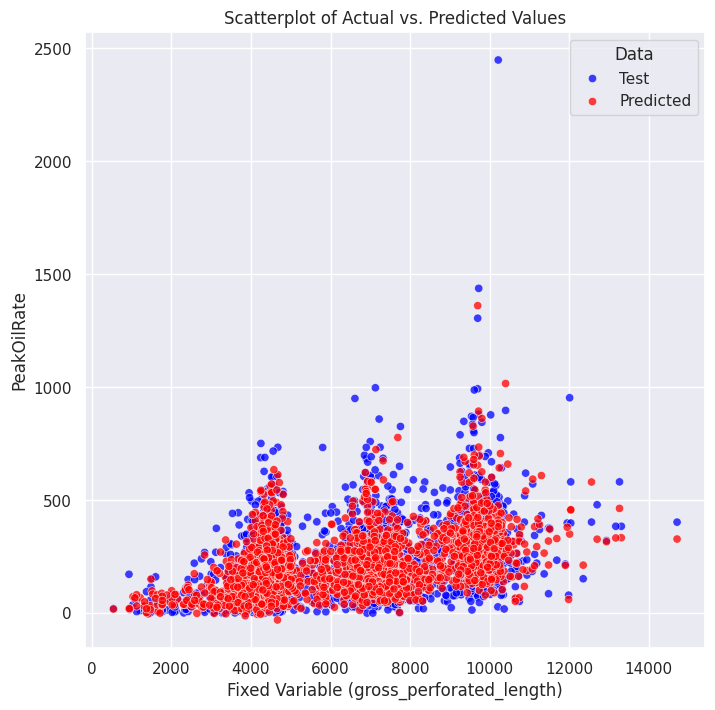

In [ ]:
# Create a DataFrame with actual values
scatter_data_actual = pd.DataFrame({
    'gross_perforated_length': X_test_no_nan['gross_perforated_length'],
    'y': y_test_no_nan.to_numpy().flatten(),
    'Data': ['Test' for _ in range(len(y_test_no_nan))]
})

# Create a DataFrame with predicted values
scatter_data_predicted = pd.DataFrame({
    'gross_perforated_length': X_test_no_nan['gross_perforated_length'],
    'y': y_pred,
    'Data': ['Predicted' for _ in range(len(y_pred))]
})

# Concatenate the two DataFrames
scatter_data = pd.concat([scatter_data_actual, scatter_data_predicted])

# Create a scatterplot with different colors for actual and predicted values
plt.figure(figsize=(8, 8))
sns.scatterplot(x='gross_perforated_length', y='y', hue='Data', data=scatter_data, palette={'Test': 'blue', 'Predicted': 'red'},
                alpha= 0.75)
plt.title('Scatterplot of Actual vs. Predicted Values')
plt.xlabel('Fixed Variable (gross_perforated_length)')
plt.ylabel('PeakOilRate')
plt.legend(title='Data')
plt.show()

(2842, 1)

#LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
# Get the feature names after one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the LightGBM pipeline with preprocessing
lightgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lightgbm', lgb.LGBMRegressor(random_state=20, objective='regression'))
])

# Fit the LightGBM pipeline on the training data
lightgbm_pipeline.fit(X_train_no_nan, y_train_no_nan)

# Predict on the validation set
y_pred = lightgbm_pipeline.predict(X_valid_no_nan)

# Calculate the root mean squared error on the validation set
rmse = mean_squared_error(y_valid_no_nan, y_pred, squared = False)
print(f'Root Mean Squared Error on Validation Set: {rmse}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3626
[LightGBM] [Info] Number of data points in the train set: 13419, number of used features: 40
[LightGBM] [Info] Start training from score 220.801933
Root Mean Squared Error on Validation Set: 96.33562812023408


In [ ]:
# Get the feature names after one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the LightGBM pipeline with preprocessing
# Define the LightGBM pipeline with preprocessing
lightgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lightgbm', lgb.LGBMRegressor(random_state=20, objective='regression'))
])

# Define the hyperparameter grid to search over
param_grid = {
    'lightgbm__n_estimators': [100, 200, 300],  # Number of trees
    'lightgbm__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'lightgbm__max_depth': [5, 10, 15],  # Maximum depth of trees
    'lightgbm__min_child_samples': [5, 10, 20]  # Minimum number of samples in leaf nodes
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=lightgbm_pipeline, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_no_nan, y_train_no_nan)

# Get the best hyperparameters
best_params = grid_search.best_params_
print(f'Best Hyperparameters: {best_params}')

# Predict on the validation set using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid_no_nan)

# Calculate the root mean squared error on the validation set
rmse = np.sqrt(mean_squared_error(y_valid_no_nan, y_pred))
print(f'Root Mean Squared Error on Validation Set: {rmse}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3626
[LightGBM] [Info] Number of data points in the train set: 13419, number of used features: 40
[LightGBM] [Info] Start training from score 220.801933
Best Hyperparameters: {'lightgbm__learning_rate': 0.1, 'lightgbm__max_depth': 10, 'lightgbm__min_child_samples': 5, 'lightgbm__n_estimators': 300}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Root Mean Squared Error on Validation Set: 94.05647487187511


In [ ]:
# Get the feature names after one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the LightGBM pipeline with preprocessing
lightgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lightgbm', lgb.LGBMRegressor(random_state=20, objective='regression',
                                   learning_rate = 0.1, max_depth = 10, n_estimators= 300,
                                   min_child_samples= 5))
])

# Fit the LightGBM pipeline on the training data
lightgbm_pipeline.fit(X_combined_no_nan, y_combined_no_nan)

# Predict on the validation set
y_pred = lightgbm_pipeline.predict(X_test_no_nan)

# Calculate the root mean squared error on the validation set
rmse = mean_squared_error(y_test_no_nan, y_pred, squared = False)
print(f'Root Mean Squared Error on Validation Set: {rmse}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3626
[LightGBM] [Info] Number of data points in the train set: 16281, number of used features: 40
[LightGBM] [Info] Start training from score 220.074552
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Root Mean Squared Error on Validation Set: 104.10748549958613


Default

In [ ]:
# Get the feature names after one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the LightGBM pipeline with preprocessing
lightgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lightgbm', lgb.LGBMRegressor(random_state=20, objective='regression'))
])

# Fit the LightGBM pipeline on the training data
lightgbm_pipeline.fit(X_combined_no_nan, y_combined_no_nan)

# Predict on the validation set
y_pred = lightgbm_pipeline.predict(X_test_no_nan)

# Calculate the root mean squared error on the validation set
rmse = mean_squared_error(y_test_no_nan, y_pred, squared = False)
print(f'Root Mean Squared Error on Validation Set: {rmse}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3626
[LightGBM] [Info] Number of data points in the train set: 16281, number of used features: 40
[LightGBM] [Info] Start training from score 220.074552
Root Mean Squared Error on Validation Set: 105.77839533170018


#Feature Importance

Mean Squared Error: 112.37275319638968


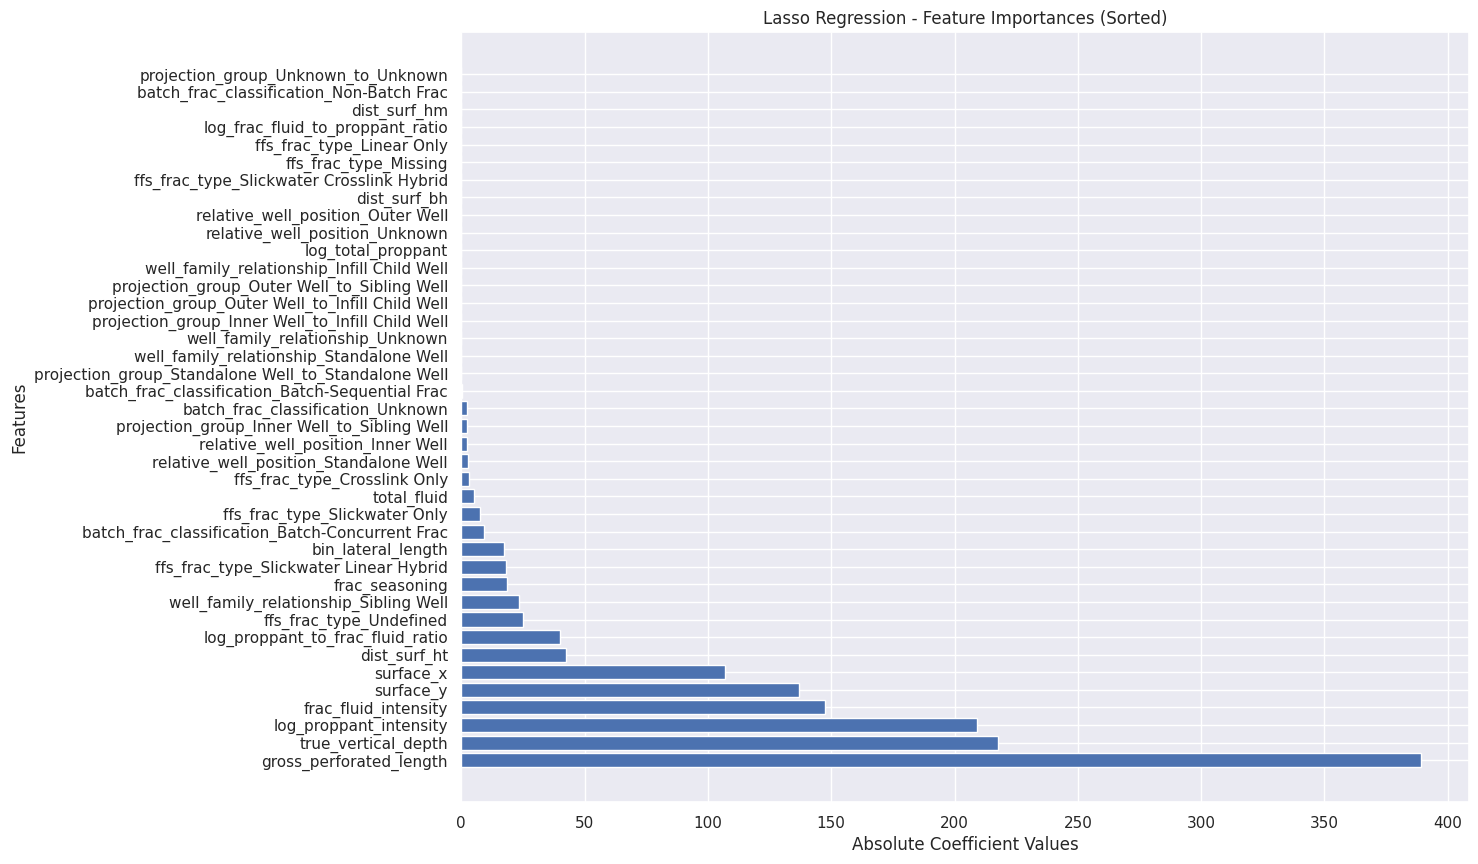

In [ ]:
# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the pipeline with preprocessing and Lasso regression
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso(random_state=20, alpha=0.1))  # Adjust the alpha parameter as needed
])

# Fit the Lasso pipeline
lasso_pipeline.fit(X_train_no_nan, y_train_no_nan)

# Evaluate the model on the test set
y_pred = lasso_pipeline.predict(X_valid_no_nan)
mse = mean_squared_error(y_valid_no_nan, y_pred, squared = False)
print(f'Mean Squared Error: {mse}')

# Get the feature names after one-hot encoding
feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + feature_names.tolist()

# Extract coefficients from the Lasso model
coefficients = lasso_pipeline.named_steps['lasso'].coef_

# Plot the absolute values of coefficients as feature importances in descending order
sorted_indices = np.argsort(-abs(coefficients))  # Sort indices in descending order
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = np.array(all_feature_names)[sorted_indices]

# Plot the absolute values of coefficients as feature importances
plt.figure(figsize=(13, 10))
plt.barh(range(len(sorted_feature_names)), abs(sorted_coefficients))
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.title('Lasso Regression - Feature Importances (Sorted)')
plt.xlabel('Absolute Coefficient Values')
plt.ylabel('Features')
plt.show()

Mean Squared Error: 112.99552413952408


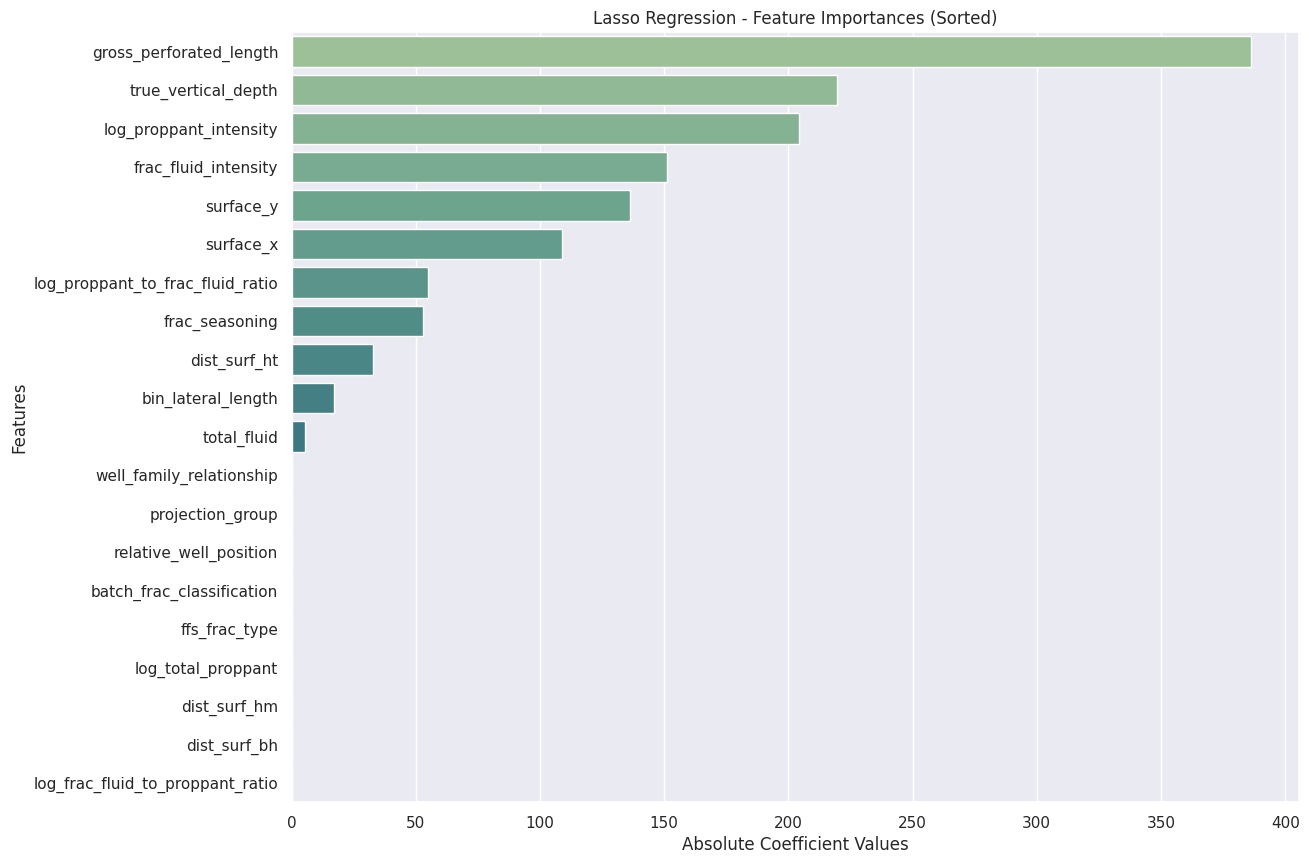

In [ ]:
# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', CountEncoder(), categorical_features)
    ])

# Define the pipeline with preprocessing and Lasso regression
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso(random_state=20, alpha=0.1))  # Adjust the alpha parameter as needed
])

# Fit the Lasso pipeline
lasso_pipeline.fit(X_train_no_nan, y_train_no_nan)

# Evaluate the model on the test set
y_pred = lasso_pipeline.predict(X_valid_no_nan)
mse = mean_squared_error(y_valid_no_nan, y_pred, squared = False)
print(f'Mean Squared Error: {mse}')

# Get the feature names after one-hot encoding
#feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
#all_feature_names = numerical_features + feature_names.tolist()

# Extract coefficients from the Lasso model
coefficients = lasso_pipeline.named_steps['lasso'].coef_

# Plot the absolute values of coefficients as feature importances in descending order
sorted_indices = np.argsort(-abs(coefficients))  # Sort indices in descending order
sorted_coefficients = coefficients[sorted_indices]
sorted_feature_names = np.array(features)[sorted_indices]

sns.set_theme()
plt.figure(figsize=(13, 10))
sns.barplot(x=abs(sorted_coefficients), y=sorted_feature_names, orient='h', palette='crest')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.title('Lasso Regression - Feature Importances (Sorted)')
plt.xlabel('Absolute Coefficient Values')
plt.ylabel('Features')
plt.show()

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
    ])

# Define the pipeline with preprocessing and CatBoost Regressor
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('catboost', CatBoostRegressor(random_state=20, objective='RMSE'))  # Adjust parameters as needed
])

# Fit the CatBoost pipeline on the training data
catboost_pipeline.fit(X_combined_no_nan, y_combined_no_nan)

# Predict on the validation set
y_pred = catboost_pipeline.predict(X_test_no_nan)

# Calculate the root mean squared error on the validation set
rmse = np.sqrt(mean_squared_error(y_test_no_nan, y_pred))
print(f'Root Mean Squared Error on Test Set: {rmse}')

features = numerical_features + categorical_features
# Get feature names from the preprocessor
feature_names = catboost_pipeline.named_steps['preprocessor'].transformers_[0][1]\
                .get_feature_names_out(input_features=numerical_features)

# Get feature importance from CatBoost
feature_importance = catboost_pipeline.named_steps['catboost'].get_feature_importance()

# Create a DataFrame with feature names and their importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a barplot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='crest')
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Learning rate set to 0.063625
0:	learn: 150.9482836	total: 13.7ms	remaining: 13.7s
1:	learn: 147.7841317	total: 21.1ms	remaining: 10.5s
2:	learn: 144.8615899	total: 28.4ms	remaining: 9.43s
3:	learn: 142.1222075	total: 35.6ms	remaining: 8.86s
4:	learn: 139.8061254	total: 42.4ms	remaining: 8.45s
5:	learn: 137.5158089	total: 51.3ms	remaining: 8.5s
6:	learn: 135.5074857	total: 58.1ms	remaining: 8.24s
7:	learn: 133.5573478	total: 65.5ms	remaining: 8.13s
8:	learn: 131.9584460	total: 72.3ms	remaining: 7.96s
9:	learn: 130.3269599	total: 78.8ms	remaining: 7.8s
10:	learn: 128.6955977	total: 86ms	remaining: 7.73s
11:	learn: 127.4712656	total: 93.1ms	remaining: 7.67s
12:	learn: 126.2061333	total: 102ms	remaining: 7.74s
13:	learn: 125.0483888	total: 113ms	remaining: 7.96s
14:	learn: 123.9923686	total: 121ms	remaining: 7.97s
15:	learn: 123.0927778	total: 128ms	remaining: 7.89s
16:	learn: 122.1620378	total: 135ms	remaining: 7.82s
17:	learn: 121.3340532	total: 142ms	remaining: 7.76s
18:	learn: 120.519

ValueError: operands could not be broadcast together with shapes (15,) (5,) 

Learning rate set to 0.063625
0:	learn: 151.2013869	total: 7.6ms	remaining: 7.59s
1:	learn: 148.0626336	total: 14.7ms	remaining: 7.33s
2:	learn: 145.1263576	total: 21.6ms	remaining: 7.19s
3:	learn: 142.4002730	total: 32.3ms	remaining: 8.03s
4:	learn: 139.7459419	total: 39.7ms	remaining: 7.9s
5:	learn: 137.2959406	total: 53.2ms	remaining: 8.82s
6:	learn: 135.4381730	total: 61.8ms	remaining: 8.76s
7:	learn: 133.4912626	total: 69.4ms	remaining: 8.6s
8:	learn: 131.7884958	total: 76.4ms	remaining: 8.41s
9:	learn: 130.2216125	total: 83.8ms	remaining: 8.3s
10:	learn: 128.6800047	total: 91.3ms	remaining: 8.21s
11:	learn: 127.3044139	total: 98.5ms	remaining: 8.11s
12:	learn: 126.0410430	total: 106ms	remaining: 8.02s
13:	learn: 124.8959640	total: 113ms	remaining: 7.98s
14:	learn: 123.7538649	total: 121ms	remaining: 7.94s
15:	learn: 122.7960937	total: 128ms	remaining: 7.9s
16:	learn: 121.7922064	total: 136ms	remaining: 7.85s
17:	learn: 120.9508614	total: 143ms	remaining: 7.81s
18:	learn: 120.2207

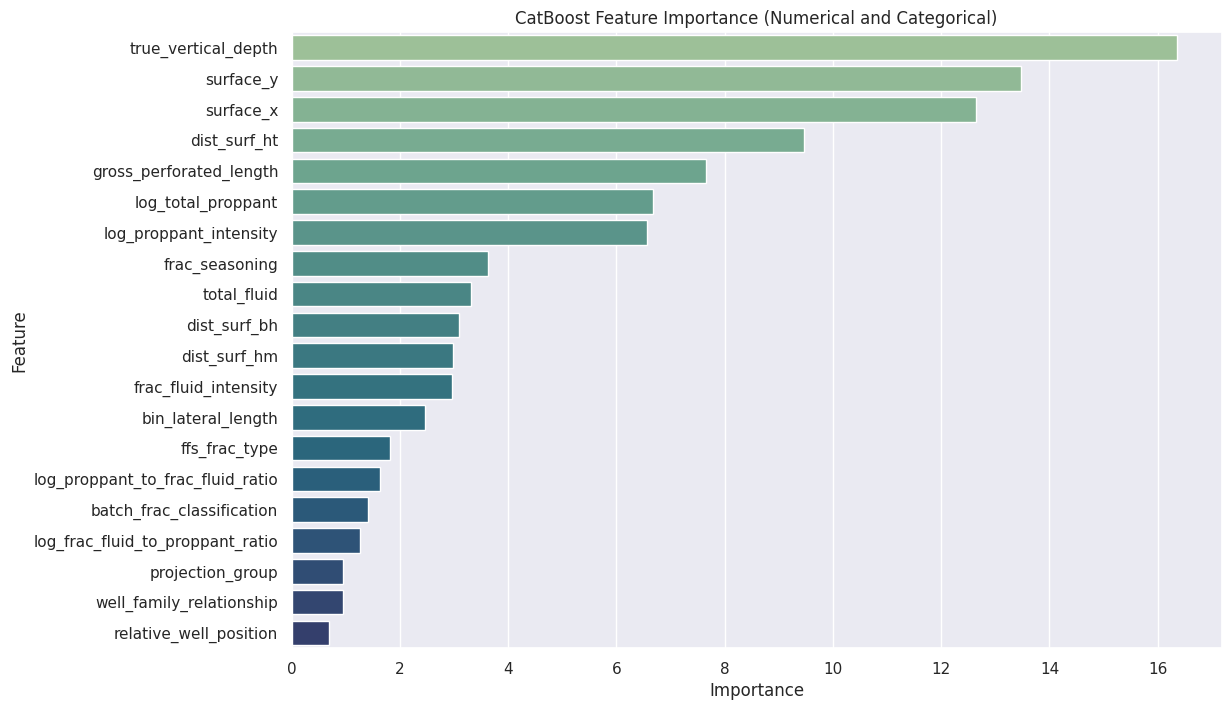

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', CountEncoder(), categorical_features)
    ])

# Define the pipeline with preprocessing and CatBoost Regressor
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('catboost', CatBoostRegressor(random_state=20, objective='RMSE'))  # Adjust parameters as needed
])

# Fit the CatBoost pipeline on the training data
catboost_pipeline.fit(X_combined_no_nan, y_combined_no_nan)

# Predict on the validation set
y_pred = catboost_pipeline.predict(X_test_no_nan)

# Calculate the root mean squared error on the validation set
rmse = np.sqrt(mean_squared_error(y_test_no_nan, y_pred))
print(f'Root Mean Squared Error on Test Set: {rmse}')

# Get feature names from the preprocessor for both numerical and categorical features
numerical_feature_names = catboost_pipeline.named_steps['preprocessor'].transformers_[0][1]\
                .get_feature_names_out(input_features=numerical_features)
categorical_feature_names = categorical_features  # Assuming categorical feature names are already defined

# Combine the numerical and categorical feature names
all_feature_names = np.concatenate([numerical_feature_names, categorical_feature_names])

# Get feature importance from CatBoost
feature_importance = catboost_pipeline.named_steps['catboost'].get_feature_importance()

# Create a DataFrame with feature names and their importance
feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a barplot
sns.set_theme()
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='crest')
plt.title('CatBoost Feature Importance (Numerical and Categorical)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Statistical Significance?

In [ ]:
import statsmodels.api as sm

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', CountEncoder(), categorical_features)
    ])

X_stat =preprocessor.fit_transform(X_combined_no_nan)
y_stat = y_combined_no_nan

X = sm.add_constant(X_stat)  # Add a constant (intercept) to the model
model = sm.OLS(y_stat, X_stat).fit()

# Print the summary statistics
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:            OilPeakRate   R-squared (uncentered):                   0.792
Model:                            OLS   Adj. R-squared (uncentered):              0.792
Method:                 Least Squares   F-statistic:                              3095.
Date:                Sun, 21 Jan 2024   Prob (F-statistic):                        0.00
Time:                        12:00:35   Log-Likelihood:                     -1.0141e+05
No. Observations:               16281   AIC:                                  2.029e+05
Df Residuals:                   16261   BIC:                                  2.030e+05
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
X_stat_df.shape

(16281, 20)

In [ ]:
y_stat.shape

(16281, 1)

# Going Deep: Neural Networks

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_combined_t = preprocessor.fit_transform(X_combined_no_nan)
X_test_t = preprocessor.transform(X_test_no_nan)

n_input = X_combined_t.shape[1]

# Create a 3-layer neural network
model = MLPRegressor(hidden_layer_sizes=(5*n_input, int(2.5*n_input),n_input//4), activation='relu', solver='adam', random_state=20)

# Fit the model to the training data
model.fit(X_combined_t, y_combined_no_nan)

# Predict on the test data
y_pred = model.predict(X_test_t)

rmse = mean_squared_error(y_test_no_nan, y_pred, squared = False)
print(f'Root Mean Squared Error on Test Set: {rmse}')

Root Mean Squared Error on Test Set: 126.2167895872308


# Log Transformation of Target data?


<Axes: ylabel='Density'>

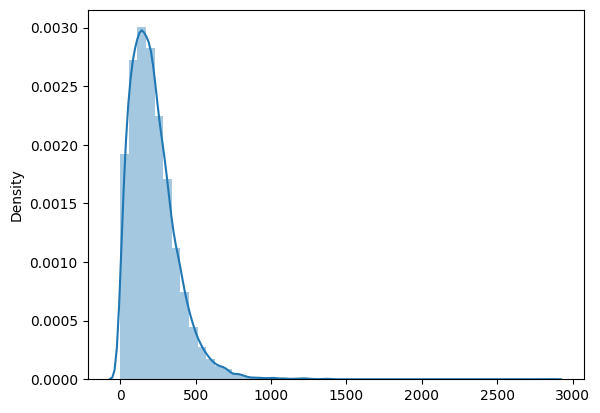

In [ ]:
sns.distplot(y_combined_no_nan)

In [ ]:
(y_combined_no_nan == 0).sum()

OilPeakRate    0
dtype: int64

<Axes: ylabel='Density'>

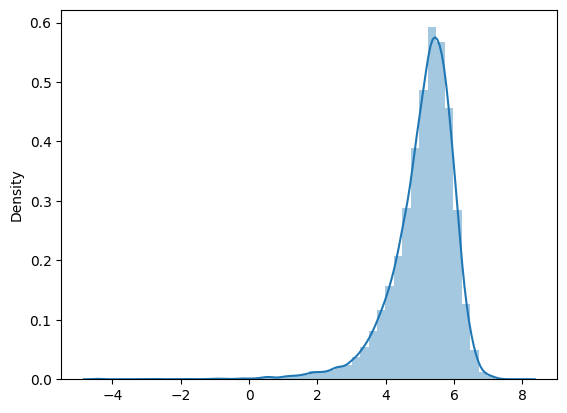

In [ ]:
moo = np.log(y_combined_no_nan)
sns.distplot(moo)

In [ ]:
# Log transformations

y_train_log = np.log(y_train_no_nan)
y_valid_log = np.log(y_valid_no_nan)
y_test_log = np.log(y_test_no_nan)
y_combined_log = np.log(y_combined_no_nan)


Lasso

In [ ]:
# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Define the pipeline with preprocessing and Lasso regression
lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', Lasso(random_state=20))
])

# Fit the Lasso pipeline
lasso_pipeline.fit(X_train_no_nan, y_train_log)

# Evaluate the model on the test set
y_pred = np.exp(lasso_pipeline.predict(X_valid_no_nan))
mse = mean_squared_error(y_valid_no_nan, y_pred, squared = False)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 157.56066587023463


CatBoost

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
    ])

# Define the pipeline with preprocessing and CatBoost Regressor
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('catboost', CatBoostRegressor(random_state=20, objective='RMSE',learning_rate = 0.1, depth = 7))
])

# Fit the CatBoost pipeline on the training data
catboost_pipeline.fit(X_train_no_nan, y_train_log)

# Predict on the validation set
y_pred = np.exp(catboost_pipeline.predict(X_valid_no_nan))

# Calculate the root mean squared error on the validation set
rmse = np.sqrt(mean_squared_error(y_valid_no_nan, y_pred))
print(f'Root Mean Squared Error on Validation Set: {rmse}')

0:	learn: 0.9092470	total: 8.83ms	remaining: 8.82s
1:	learn: 0.8806331	total: 18.3ms	remaining: 9.13s
2:	learn: 0.8549187	total: 26.8ms	remaining: 8.89s
3:	learn: 0.8316489	total: 36.5ms	remaining: 9.1s
4:	learn: 0.8131806	total: 45.2ms	remaining: 8.99s
5:	learn: 0.7971650	total: 53.7ms	remaining: 8.9s
6:	learn: 0.7829870	total: 62.4ms	remaining: 8.86s
7:	learn: 0.7691992	total: 74.1ms	remaining: 9.19s
8:	learn: 0.7571301	total: 85.7ms	remaining: 9.43s
9:	learn: 0.7470018	total: 94.6ms	remaining: 9.36s
10:	learn: 0.7388283	total: 103ms	remaining: 9.3s
11:	learn: 0.7305699	total: 112ms	remaining: 9.25s
12:	learn: 0.7234269	total: 121ms	remaining: 9.2s
13:	learn: 0.7157141	total: 130ms	remaining: 9.17s
14:	learn: 0.7097929	total: 140ms	remaining: 9.17s
15:	learn: 0.7040202	total: 152ms	remaining: 9.36s
16:	learn: 0.6996370	total: 161ms	remaining: 9.33s
17:	learn: 0.6947792	total: 170ms	remaining: 9.27s
18:	learn: 0.6914752	total: 179ms	remaining: 9.23s
19:	learn: 0.6879589	total: 188ms	r

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
    ])

# Define the pipeline with preprocessing and CatBoost Regressor
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('catboost', CatBoostRegressor(random_state=20, objective='RMSE',learning_rate = 0.1, depth = 7))  # Adjust parameters as needed
])

# Fit the CatBoost pipeline on the training data
catboost_pipeline.fit(X_combined_no_nan, y_combined_log)

# Predict on the validation set
y_pred = np.exp(catboost_pipeline.predict(X_test_no_nan))

# Calculate the root mean squared error on the validation set
rmse = np.sqrt(mean_squared_error(y_test_log, y_pred))
print(f'Root Mean Squared Error on Validation Set: {rmse}')

0:	learn: 0.9101411	total: 27ms	remaining: 27s
1:	learn: 0.8804362	total: 37.1ms	remaining: 18.5s
2:	learn: 0.8559015	total: 46.3ms	remaining: 15.4s
3:	learn: 0.8325512	total: 55.9ms	remaining: 13.9s
4:	learn: 0.8145452	total: 65.7ms	remaining: 13.1s
5:	learn: 0.7991242	total: 75.4ms	remaining: 12.5s
6:	learn: 0.7851834	total: 85.5ms	remaining: 12.1s
7:	learn: 0.7729032	total: 97ms	remaining: 12s
8:	learn: 0.7611855	total: 106ms	remaining: 11.7s
9:	learn: 0.7520958	total: 116ms	remaining: 11.5s
10:	learn: 0.7421102	total: 131ms	remaining: 11.8s
11:	learn: 0.7352342	total: 152ms	remaining: 12.5s
12:	learn: 0.7278604	total: 162ms	remaining: 12.3s
13:	learn: 0.7218373	total: 172ms	remaining: 12.1s
14:	learn: 0.7160851	total: 181ms	remaining: 11.9s
15:	learn: 0.7117832	total: 195ms	remaining: 12s
16:	learn: 0.7073488	total: 206ms	remaining: 11.9s
17:	learn: 0.7020510	total: 215ms	remaining: 11.8s
18:	learn: 0.6990194	total: 231ms	remaining: 11.9s
19:	learn: 0.6957441	total: 241ms	remaining

# Models vs Models vs Stacking

In [ ]:
# MODELS
lasso = Lasso(random_state=20, alpha=0.1)
ridge = Ridge(random_state=20, alpha=20)
elastic_net = ElasticNet(random_state=10, alpha=0.01, l1_ratio = 0.6)
xgboost = XGBRegressor(random_state = 20, max_depth= 8, subsample=  0.8)
lightgbm = lgb.LGBMRegressor(random_state=20, objective='regression',
                                   learning_rate = 0.1, max_depth = 10, n_estimators= 300,
                                   min_child_samples= 5)

catbost = CatBoostRegressor(random_state=20, objective='RMSE', learning_rate = 0.1)



In [ ]:
models = [('lasso',lasso ),
          ('ridge',ridge),
          ('elastic_net',elastic_net),
          ('xgboost', xgboost),
          ('lightgbm', lightgbm),
          ('catbost',catbost)]

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X_combined_pre  = preprocessor.fit_transform(X_combined_no_nan)
y_combined = y_combined_no_nan

X_test_pre = preprocessor.transform(X_test_no_nan)
y_test = y_test_no_nan


MSE = []
for model in models:
  print(model[0])
  model[1].fit(X_combined_pre,y_combined )
  MSE.append(mean_squared_error(y_pred= model[1].predict(X_test_pre), y_true= y_test))



lasso
ridge
elastic_net
xgboost
lightgbm
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3627
[LightGBM] [Info] Number of data points in the train set: 16281, number of used features: 40
[LightGBM] [Info] Start training from score 220.074552
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
catbost
0:	learn: 148.7757179	total: 67.9ms	remaining: 1m 7s
1:	learn: 144.0335206	total: 96.7ms	remaining: 48.2s
2:	learn: 140.0487073	total: 157ms	remaining: 52s
3:	learn: 136.3517549	total: 194ms	remaining: 48.4s
4:	learn:

In [ ]:
print(np.sqrt(MSE))

[139.62619872 142.63432609 141.68846139 105.13540789 101.05072204
 100.31976258]


In [ ]:
MSE_s = {'MODEL':['lasso','ridge','elastic_net','xgboost','lightgbm','catbost'], 'RMSE': np.sqrt(MSE)}

pd.DataFrame(MSE_s)

,MODEL,RMSE
0,lasso,139.626199
1,ridge,142.634326
2,elastic_net,141.688461
3,xgboost,105.135408
4,lightgbm,101.050722
5,catbost,100.319763


#Final Data

In [ ]:
scoring.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        400 non-null    int64  
 1   surface_x                         400 non-null    float64
 2   surface_y                         400 non-null    float64
 3   standardized_operator_name        400 non-null    int64  
 4   gross_perforated_length           400 non-null    float64
 5   number_of_stages                  400 non-null    float64
 6   total_fluid                       400 non-null    float64
 7   true_vertical_depth               400 non-null    float64
 8   ffs_frac_type                     400 non-null    object 
 9   frac_fluid_intensity              400 non-null    float64
 10  average_stage_length              400 non-null    float64
 11  average_proppant_per_stage        400 non-null    float64
 12  average_

In [ ]:
X_combined_no_nan.shape

(16281, 20)

In [ ]:
features = X_combined_no_nan.columns

In [ ]:
target = ['PeakOilRate']

In [ ]:
scoring[features]

,surface_x,surface_y,gross_perforated_length,bin_lateral_length,frac_seasoning,dist_surf_bh,dist_surf_hm,dist_surf_ht,log_total_proppant,total_fluid,true_vertical_depth,log_proppant_intensity,frac_fluid_intensity,log_proppant_to_frac_fluid_ratio,log_frac_fluid_to_proppant_ratio,ffs_frac_type,relative_well_position,batch_frac_classification,well_family_relationship,projection_group
0,9.471472e+05,1.035963e+06,6370.078740,1.5,60.0,6978.867592,3911.565708,82802.067132,12.794256,2.049015e+06,8337.598425,4.034889,321.662440,-1.738614,1.738614,Slickwater Crosslink Hybrid,Outer Well,Non-Batch Frac,Sibling Well,Outer Well_to_Sibling Well
1,9.556775e+05,1.046164e+06,5244.094488,1.0,6.0,6027.179384,3330.385111,96052.745112,12.839242,1.876124e+06,8808.070866,4.274384,357.759307,-1.605476,1.605476,Slickwater Crosslink Hybrid,Standalone Well,Non-Batch Frac,Standalone Well,Standalone Well_to_Standalone Well
2,9.546967e+05,1.045332e+06,6694.881890,1.5,29.0,7373.306979,4108.811694,97461.815982,12.990626,2.773870e+06,8638.779528,4.181528,414.326910,-1.845128,1.845128,Slickwater Crosslink Hybrid,Outer Well,Non-Batch Frac,Infill Child Well,Outer Well_to_Infill Child Well
3,9.580318e+05,1.040111e+06,6694.881890,1.5,29.0,13077.532276,1091.438144,80743.332717,12.990626,2.773870e+06,8536.417323,4.181528,414.326910,-1.845128,1.845128,Slickwater Crosslink Hybrid,Standalone Well,Unknown,Standalone Well,Standalone Well_to_Standalone Well
4,9.679726e+05,1.038412e+06,2520.669291,1.0,29.0,4333.335619,2693.561859,74417.415120,12.520362,1.340587e+06,8668.307087,4.688082,531.837898,-1.588257,1.588257,Slickwater Crosslink Hybrid,Standalone Well,Unknown,Standalone Well,Standalone Well_to_Standalone Well
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1.482062e+06,9.541835e+05,4302.165354,1.0,29.0,4933.314029,2872.281140,522939.817138,12.279721,1.163932e+06,5226.377953,3.912848,270.545556,-1.687593,1.687593,Crosslink Only,Outer Well,Unknown,Infill Child Well,Outer Well_to_Infill Child Well
396,1.481784e+06,9.519994e+05,4342.519685,1.0,36.0,5035.257836,2965.137626,524800.543926,12.339604,1.303240e+06,5245.078740,3.963394,300.111524,-1.740760,1.740760,Crosslink Only,Standalone Well,Non-Batch Frac,Standalone Well,Standalone Well_to_Standalone Well
397,1.470326e+06,9.259947e+05,7380.905512,1.5,36.0,8139.975170,4468.580413,536218.670806,13.018906,2.174185e+06,5288.385827,4.112254,294.568916,-1.573259,1.573259,Crosslink Only,Standalone Well,Unknown,Standalone Well,Standalone Well_to_Standalone Well
398,1.432107e+06,9.590904e+05,7357.283465,1.5,36.0,7746.782062,4199.872656,465371.062396,12.340229,1.035400e+06,5109.251969,3.436783,140.731313,-1.510070,1.510070,Crosslink Only,Standalone Well,Unknown,Standalone Well,Standalone Well_to_Standalone Well


In [ ]:
model = CatBoostRegressor(random_state=20, objective='RMSE', learning_rate = 0.1)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ])